In [1]:
!pip install pyPortfolioOpt
!pip install yfinance

     ---------------------------------------- 0.0/61.9 kB ? eta -:--:--
     ------ --------------------------------- 10.2/61.9 kB ? eta -:--:--
     ------------ ------------------------- 20.5/61.9 kB 162.5 kB/s eta 0:00:01
     ------------------------- ------------ 41.0/61.9 kB 245.8 kB/s eta 0:00:01
     -------------------------------------  61.4/61.9 kB 326.1 kB/s eta 0:00:01
     -------------------------------------- 61.9/61.9 kB 300.6 kB/s eta 0:00:00
  Obtaining dependency information for cvxpy<2.0.0,>=1.1.19 from https://files.pythonhosted.org/packages/09/b7/42d8af9fb2963df3afdd35e476c4997798f87e783acf8600ff2728589412/cvxpy-1.4.1-cp310-cp310-win_amd64.whl.metadata
  Obtaining dependency information for osqp>=0.6.2 from https://files.pythonhosted.org/packages/b1/e6/fa46181c0f7164704ad501a71191e3890db27461cb4d2ab92c0f37671201/osqp-0.6.3-cp310-cp310-win_amd64.whl.metadata
     ---------------------------------------- 0.0/72.0 kB ? eta -:--:--
     ------------------------------

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import datetime
import yfinance as yf
yf.pdr_override()

%matplotlib inline

In [3]:
start_date = datetime.datetime(2021,4,1)
end_date = datetime.datetime(2023,10,31)

In [4]:
def get_stock_price(ticker):
    prices = web.get_data_yahoo(ticker,start_date,end_date)
    prices = prices["Adj Close"].dropna(how="all") 
    return prices

In [5]:
ticker_list = ['INFY.NS','TCS.NS','TATAMOTORS.NS','MARUTI.NS',
	'SUNPHARMA.NS','CIPLA.NS','ITC.NS','MARICO.NS','GOLDBEES.NS']
portfolio = get_stock_price(ticker_list)

[*********************100%%**********************]  9 of 9 completed


In [6]:
portfolio.to_csv("portfolio.csv",index=True)
portfolio = pd.read_csv("portfolio.csv",parse_dates=True,index_col="Date")

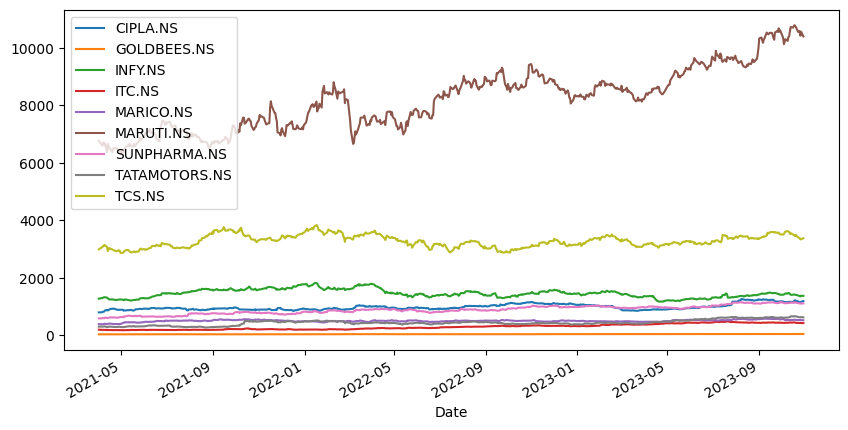

In [8]:
portfolio[portfolio.index >= "2021-04-01"].plot(figsize=(10,5));

In [10]:
import pypfopt
from pypfopt import risk_models
from pypfopt import plotting

sample_cov = risk_models.sample_cov(portfolio, frequency=252)
sample_cov 

,CIPLA.NS,GOLDBEES.NS,INFY.NS,ITC.NS,MARICO.NS,MARUTI.NS,SUNPHARMA.NS,TATAMOTORS.NS,TCS.NS
CIPLA.NS,0.051878,0.000135,0.008109,0.005174,0.011169,0.002233,0.018061,0.007906,0.007654
GOLDBEES.NS,0.000135,0.011991,0.001265,0.000765,-0.002047,-0.004169,0.000267,-0.003720,-0.000043
INFY.NS,0.008109,0.001265,0.057881,0.010541,0.008877,0.008417,0.012719,0.022561,0.033806
ITC.NS,0.005174,0.000765,0.010541,0.044302,0.010956,0.011485,0.010855,0.026953,0.006619
MARICO.NS,0.011169,-0.002047,0.008877,0.010956,0.055084,0.010444,0.011602,0.016692,0.008124
MARUTI.NS,0.002233,-0.004169,0.008417,0.011485,0.010444,0.059324,0.009254,0.039715,0.008646
SUNPHARMA.NS,0.018061,0.000267,0.012719,0.010855,0.011602,0.009254,0.046660,0.024388,0.011186
TATAMOTORS.NS,0.007906,-0.003720,0.022561,0.026953,0.016692,0.039715,0.024388,0.132190,0.021003
TCS.NS,0.007654,-0.000043,0.033806,0.006619,0.008124,0.008646,0.011186,0.021003,0.042296


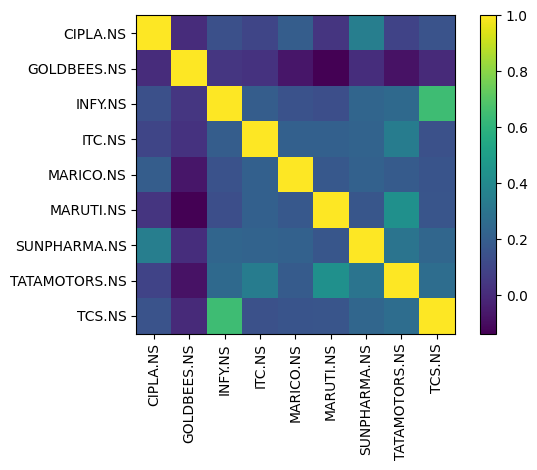

In [11]:
S = risk_models.CovarianceShrinkage(portfolio).ledoit_wolf()
plotting.plot_covariance(S, plot_correlation=True);

In [12]:
from pypfopt import expected_returns

mu = expected_returns.capm_return(portfolio)
mu

CIPLA.NS         0.165198
GOLDBEES.NS      0.025746
INFY.NS          0.232237
ITC.NS           0.185017
MARICO.NS        0.189222
MARUTI.NS        0.207898
SUNPHARMA.NS     0.207437
TATAMOTORS.NS    0.391907
TCS.NS           0.200067
Name: mkt, dtype: float64

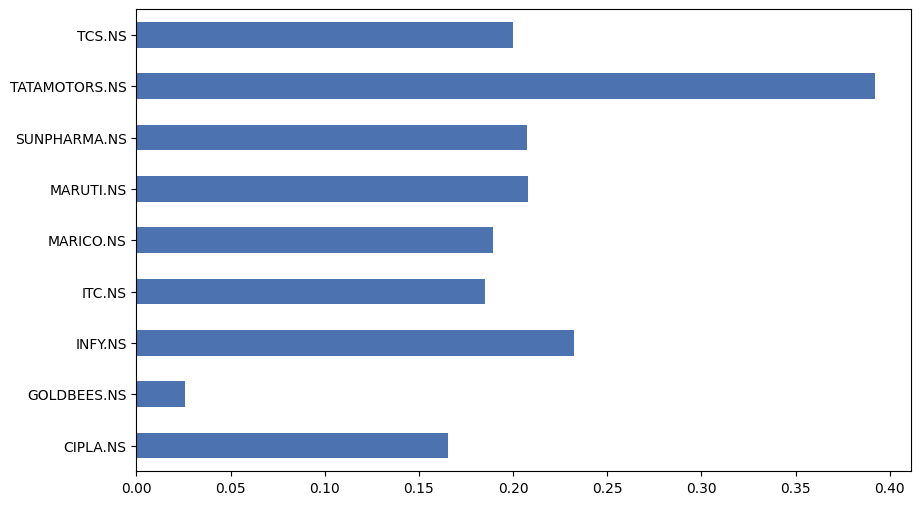

In [13]:
mu.plot.barh(figsize=(10,6));

In [14]:
from pypfopt.efficient_frontier import EfficientFrontier

ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()

cleaned_weights = ef.clean_weights()
print(dict(cleaned_weights))

{'CIPLA.NS': 0.11259, 'GOLDBEES.NS': 0.09259, 'INFY.NS': 0.11605, 'ITC.NS': 0.11258, 'MARICO.NS': 0.11266, 'MARUTI.NS': 0.11099, 'SUNPHARMA.NS': 0.11399, 'TATAMOTORS.NS': 0.11689, 'TCS.NS': 0.11166}


In [15]:
ef.portfolio_performance(verbose=True)

Expected annual return: 20.5%
Annual volatility: 12.6%
Sharpe Ratio: 1.47


(0.2049505911460792, 0.12563706729044638, 1.4721021043774642)

In [18]:
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

latest_prices = get_latest_prices(portfolio)

da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=100000)

# Number of shares of each stock to purchase
allocation, leftover = da.greedy_portfolio()
print("Discrete allocation:", allocation)
print("Funds remaining: \u20B9{:.2f}".format(leftover))

Discrete allocation: {'TATAMOTORS.NS': 18, 'INFY.NS': 8, 'SUNPHARMA.NS': 10, 'MARICO.NS': 21, 'CIPLA.NS': 9, 'ITC.NS': 26, 'TCS.NS': 4, 'MARUTI.NS': 1, 'GOLDBEES.NS': 178}
Funds remaining: ₹300.98


In [19]:
n_samples = 10000
w = np.random.dirichlet(np.ones(len(mu)), n_samples)
rets = w.dot(mu)
stds = np.sqrt((w.T * (S @ w.T)).sum(axis=0))
sharpes = rets / stds

print("Sample portfolio returns:", rets)
print("Sample portfolio volatilities:", stds)

Sample portfolio returns: [0.26758634 0.22358857 0.25074955 ... 0.19126217 0.16431472 0.24056453]
Sample portfolio volatilities: 0       0.187019
1       0.140602
2       0.171287
3       0.136799
4       0.144072
          ...   
9995    0.126820
9996    0.156026
9997    0.139692
9998    0.107391
9999    0.158304
Length: 10000, dtype: float64


C:\Users\DELL\AppData\Local\Temp\ipykernel_6776\572467462.py:19: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


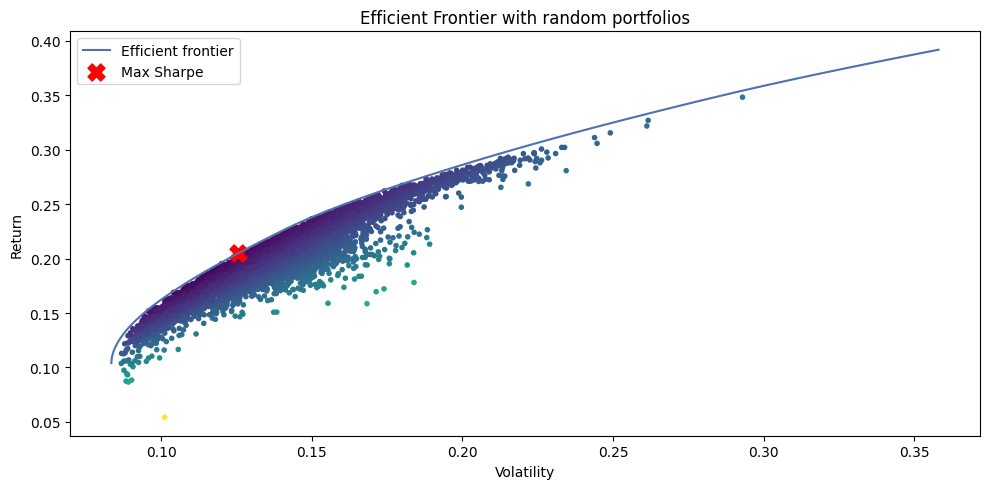

In [21]:
# Plot efficient frontier with Monte Carlo sim
ef = EfficientFrontier(mu, S)

fig, ax = plt.subplots(figsize= (10,5))
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

# Find and plot the tangency portfolio
ef2 = EfficientFrontier(mu, S)
ef2.max_sharpe()
ret_tangent, std_tangent, _ = ef2.portfolio_performance()

# Plot random portfolios
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")
ax.scatter(std_tangent, ret_tangent, c='red', marker='X',s=150, label= 'Max Sharpe')

# Format
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()
plt.show()